# Color Cycle

This notebook describes my process for choosing the color cycle used in betterplotlib. I have 3 goals for my colormap:

1. Should be colorblind friendly.
2. Should look acceptable when printed in black and white.
3. Should look good in normal conditions (i.e. non-colorblind full color)

Testing for colorblindness won't be done in this notebook, I did that by uploading my chosen colorscheme to an online colorblind simulator (see the final section). 

In [5]:
%matplotlib inline
import numpy as np
import betterplotlib as bpl
from matplotlib import colors as mpl_col
import colorsys
from PIL import Image

bpl.set_style()

I want to see what things turned to grayscale are like, which I can do with some conversions. The YIQ colorspace has visual lightness as one of the attributes, so I'll use that directly. 

In [75]:
def hex_to_yiq(hex_color):
    rgb = mpl_col.hex2color(hex_color)
    return colorsys.rgb_to_yiq(*rgb)

def hex_to_luma(hex_color):
    return hex_to_yiq(hex_color)[0]

def hex_to_hue(hex_color):
    rgb = mpl_col.hex2color(hex_color)
    hsv = mpl_col.rgb_to_hsv(rgb)
    return hsv[0]

In [7]:
def yiq_to_hex(y, i, q):
    rgb = colorsys.yiq_to_rgb(y, i, q)
    return mpl_col.rgb2hex(rgb)

In my plots I'll have one panel in full color and the other in grayscale, for comparison. Write wrappers to do that.

In [8]:
def scatter_color_and_bw(x, y, c, s, axs):
    l = hex_to_luma(c)
    axs[0].scatter(x, y, c=c, s=s)
    axs[1].scatter(x, y, c=str(l), s=s)
    
def plot_color_and_bw(x, y, c, lw, axs):
    l = hex_to_luma(c)
    axs[0].plot(x, y, c=c, lw=lw)
    axs[1].plot(x, y, c=str(l), lw=lw)

In [386]:
def plot_color_cycle(colors):
    fig, axs = bpl.subplots(ncols=4, figsize=[14, 5])
    for idx, c in enumerate(colors):
        l = hex_to_luma(c)
        h = hex_to_hue(c)
        
        scatter_color_and_bw([idx], [l], c, 2000, axs[:2])
        axs[2].scatter([idx], [h], c=c, s=2000)
        axs[3].scatter([l], [h], c=c, s=2000)
        

    for ax in axs[:2]:
        ax.set_limits(y_min=0, y_max=1)
        ax.add_labels("Color Order", "Lightness")
        
    axs[2].set_limits(y_min=0, y_max=1)
    axs[2].add_labels("Color Order", "Hue")
    
    axs[3].set_limits(y_min=0, y_max=1)
    axs[3].add_labels("Lightness", "Hue")
    axs[3].equal_scale()
    
def make_noisy_line(xs, m, b, sigma):
    noise = np.random.normal(loc=0, scale=sigma, size=len(xs))
    return m * xs + b + noise

def plot_example(colors, savename=None):
    fig, axs = bpl.subplots(ncols=2, figsize=[12, 7])
    xs = np.arange(0, 1, 0.01)
    for idx, c in enumerate(colors):
        # plot a straight line in black to compare to 
        ys = make_noisy_line(xs, idx, 0, 0.05)
        plot_color_and_bw(xs, ys, bpl.almost_black, 5, axs)
        
        ys = make_noisy_line(xs, idx, 0, 0.1)
        plot_color_and_bw(xs, ys, c, 5, axs)
        
        scatter_color_and_bw(np.random.normal(0.5, 0.1, 20),
                             np.random.normal(5, 0.5, 20),
                             c, 50, axs)
    
    for ax in axs:
        ax.fill_between(x=[0, 0.5], y1=-1000, y2=1000, color="k", zorder=-10)
        ax.set_limits(0, 1, -1, 7)
        ax.make_ax_dark()
        
    if savename is not None:
        fig.savefig(savename, dpi=100)
        
def make_plots(colors):
    plot_color_cycle(colors)
    plot_example(colors)

What I'll do to select a color cycle is to pick colors I like, then slightly adjust their Y attribute in YIQ colorspace so I can space them nicely in lightness. Then I can take them back to rgb then to hex.

I did a bunch of experimentation here to find the right colors. My process mainly involved really liking the first two colors (which I found mostly by accident, then using [pallettable](https://www.palettable.io) or [coolors](https://coolors.co) to pick other colors that fit well. This allows for lots of experimentation. I ran the choices I liked through this.

First I want to just show the raw values. 

In [458]:
turquoise = '#9BCFB3'
dark_blue = "#4B5387"
red = "#BF595C"
gray = "#888888"

In [459]:
# proposed_cycle = ["#4B5387", '#9BCFB3',  "#FF999C", "#F6E89E", "#C58A2F"] # old cycle
proposed_cycle = [dark_blue,
                  turquoise,
                  gray,
                  red,
                  "#EDC948", # yellow
                  "#6B9080", # green
                  "#DDA178", # orange/tan
                  "#6B5785", # purple
                  ]

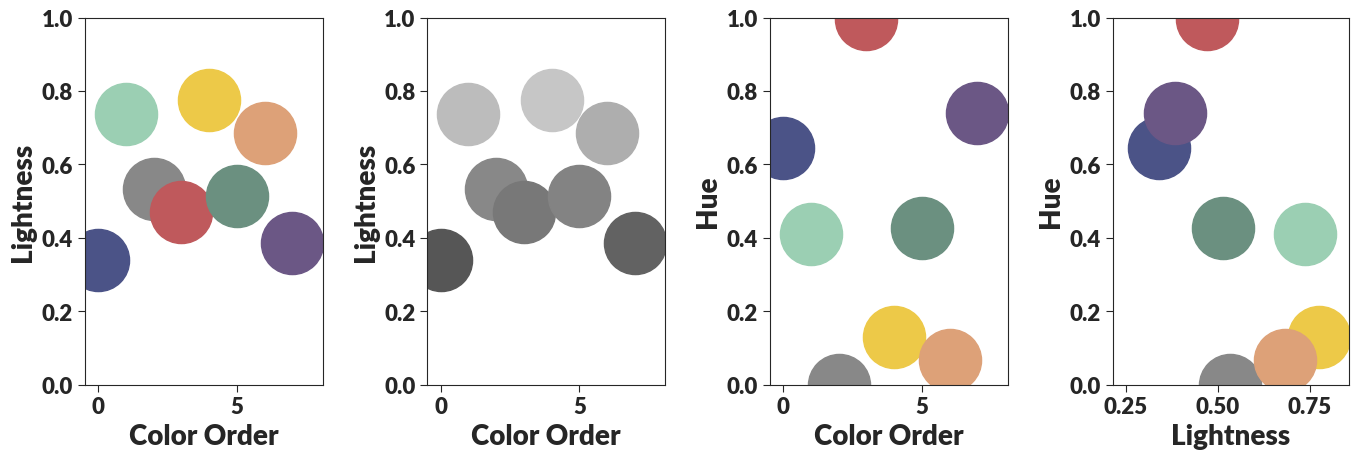

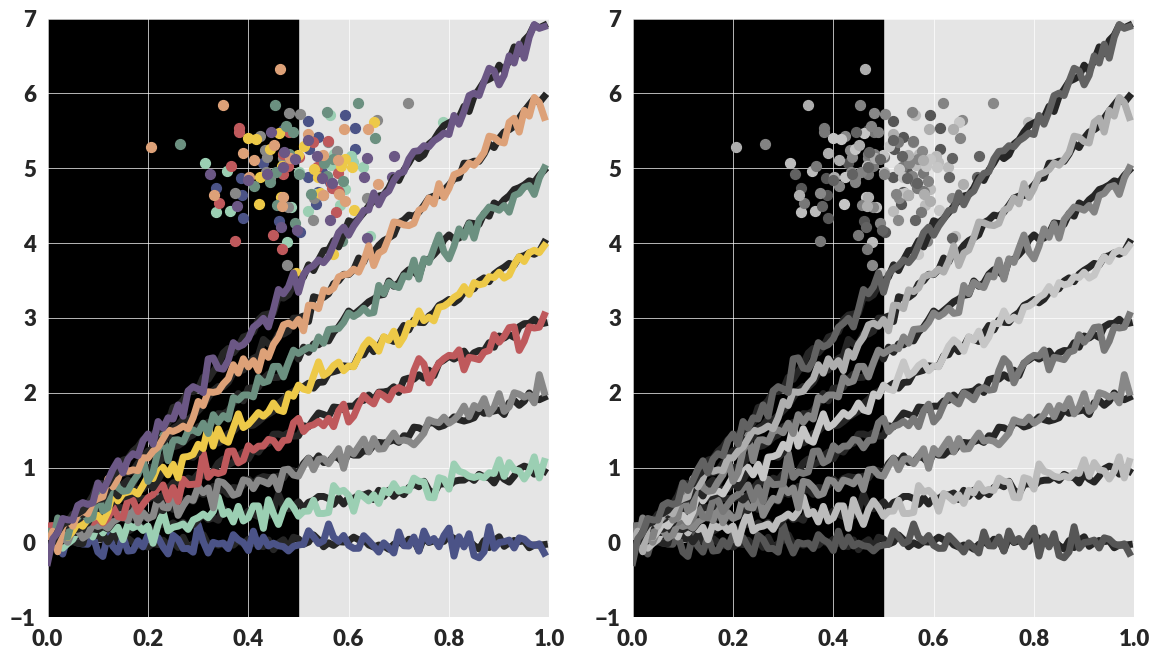

In [460]:
make_plots(proposed_cycle)

Let's try to modify these. I really like the first two colors. I don't want to change those. What I'll do is to have other colors between these in lightness (since these two are quite light/dark already). 

In [461]:
def make_lightnesses(old_colors):
    old_lightnesses = [hex_to_luma(c) for c in old_colors]
    l1 = hex_to_luma(dark_blue)
    l2 = hex_to_luma(turquoise)
    
    new_lightnesses = np.linspace(l1, l2, num=len(old_colors))
    
    # We want an order to this, to maximize differences in colors.
    # these values are just to make the color cycle look good with 
    # the chosen colors, with roughly alternating light and dark colors
    if len(old_colors) == 8:
        idxs = [0, 7, 4, 1, 6, 2, 5, 3]
    elif len(old_colors) == 7:
        idxs = [0, 6, 1, 5, 2, 4, 3]
    elif len(old_colors) == 6:
        idxs = [0, 5, 1, 4, 2, 3]
    elif len(old_colors) == 5:
        idxs= [0, 4, 1, 3, 2]
    else:
        raise ValueError("Not implemented yet")
        
    return [new_lightnesses[i] for i in idxs]

def make_new_cycle(old_colors):
    new_colors = []
    
    for c, l in zip(old_colors, make_lightnesses(old_colors)):
        y, i, q = hex_to_yiq(c)
        # then turn this back to hex, with the new lightness
        new_colors.append(yiq_to_hex(l, i, q))
        
    return new_colors

But this function is what does the heavy lifting. It takes the YIQ values of the proposed colors, the modifies the Y to get appropriate lightnesses. Then these are transformed back to hex colors.

In [462]:
new_cycle = make_new_cycle(proposed_cycle)

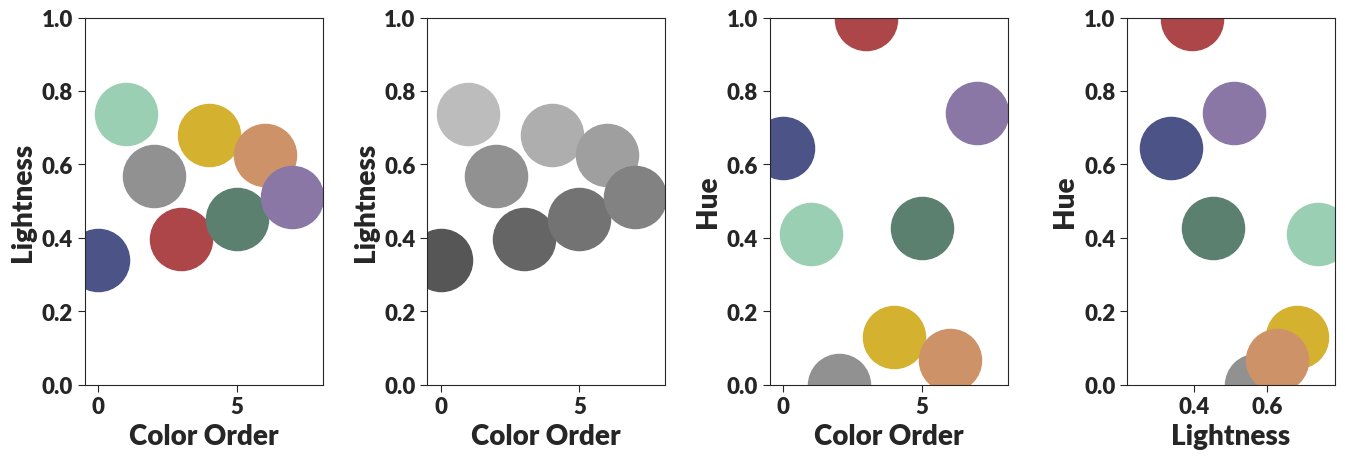

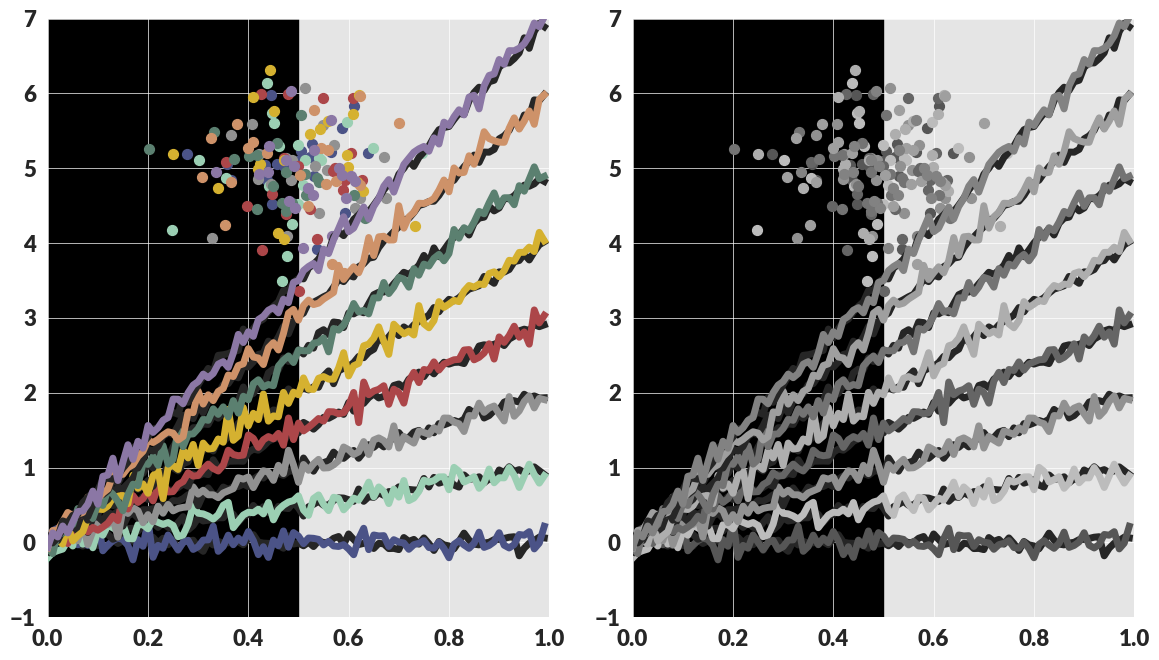

In [463]:
plot_color_cycle(new_cycle)
plot_example(new_cycle)

This looks good. The lightnesses are evenly distributed, and bounce back and forth between dark and light, so when only a few colors are used the variation in lightness is large. I think the colors are visually pleasing, even the darkest is distinguishable from black. The grayscale colors are still distinguishable from each other and black too. So these colors meet my last two criteria.

I then run this image through a [colorblind simulator](https://www.color-blindness.com/coblis-color-blindness-simulator/) keeping in mind the [fraction of people with different deficiencies](https://www.color-blindness.com/types-of-color-blindness/). [Coolors](https://coolors.co/4b5387-9bcfb3-919191-ac4649-d5b130-5b8070-ce9269-8b77a5) also has a colorblind simulator. I'm happy with these results, so this is the cycle that betterplotlib will use.

In [454]:
new_cycle

['#4b5387',
 '#9bcfb3',
 '#919191',
 '#ac4649',
 '#d5b130',
 '#5b8070',
 '#ce9269',
 '#8b77a5']

I'll also make some test plots to show various combos of colors used together. I experimented with this a bit to make the cycle be in the best order.

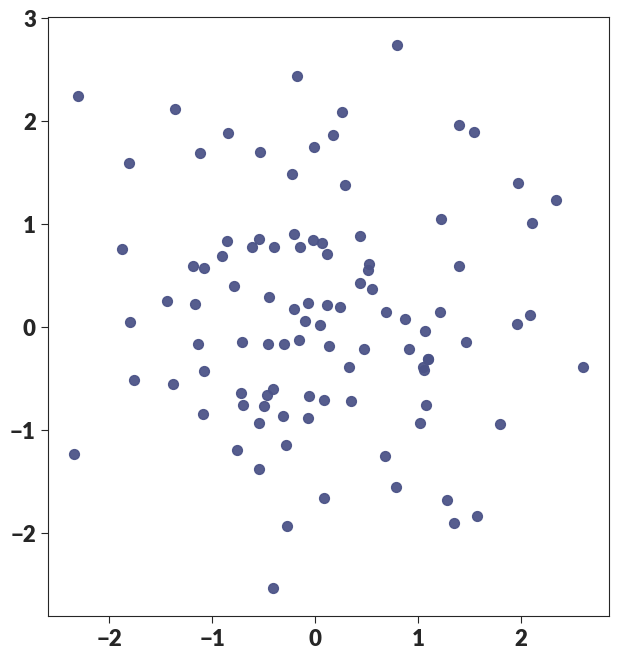

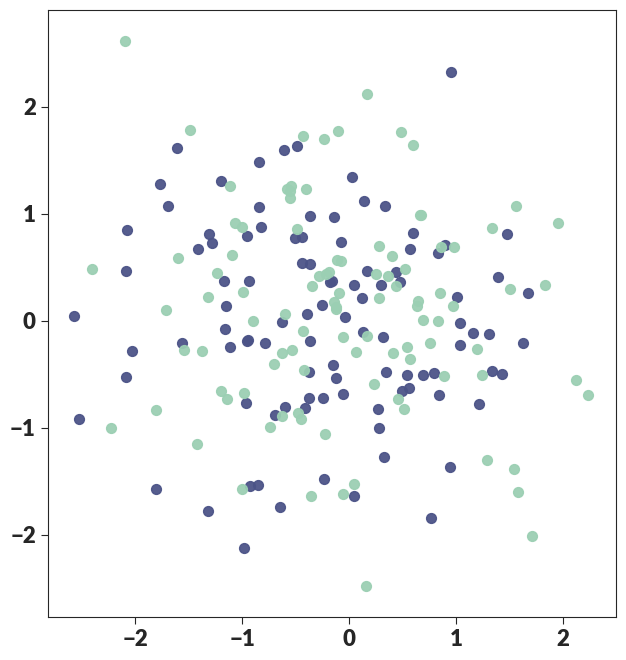

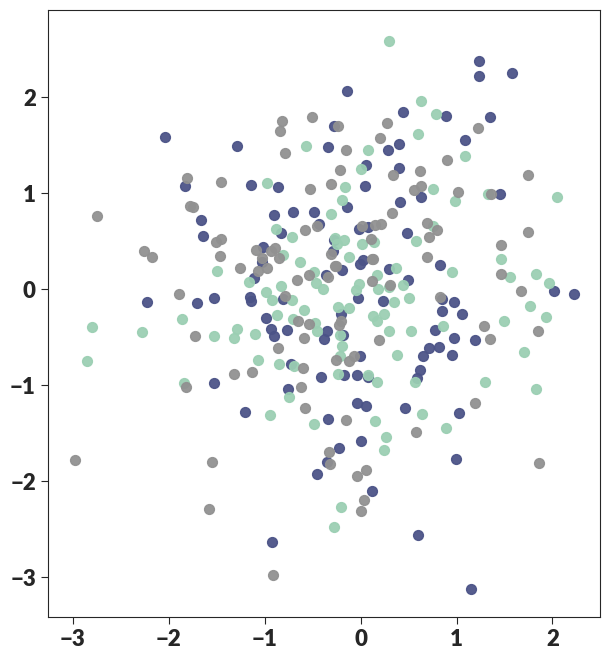

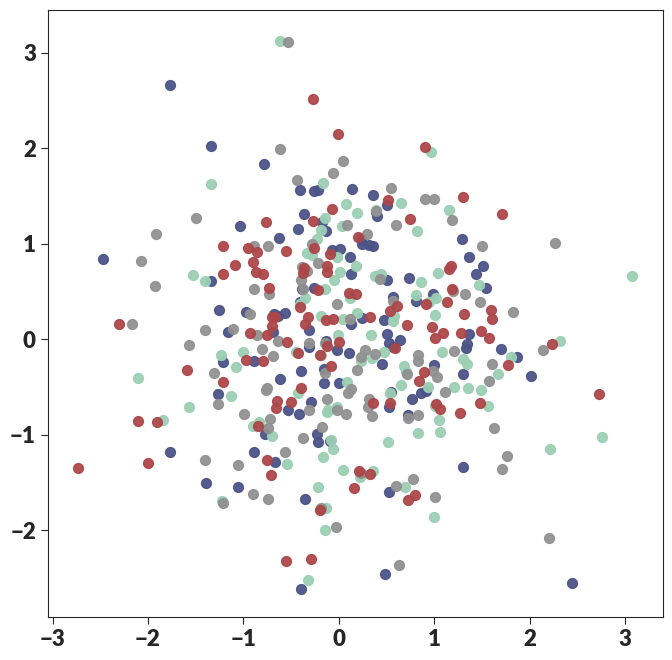

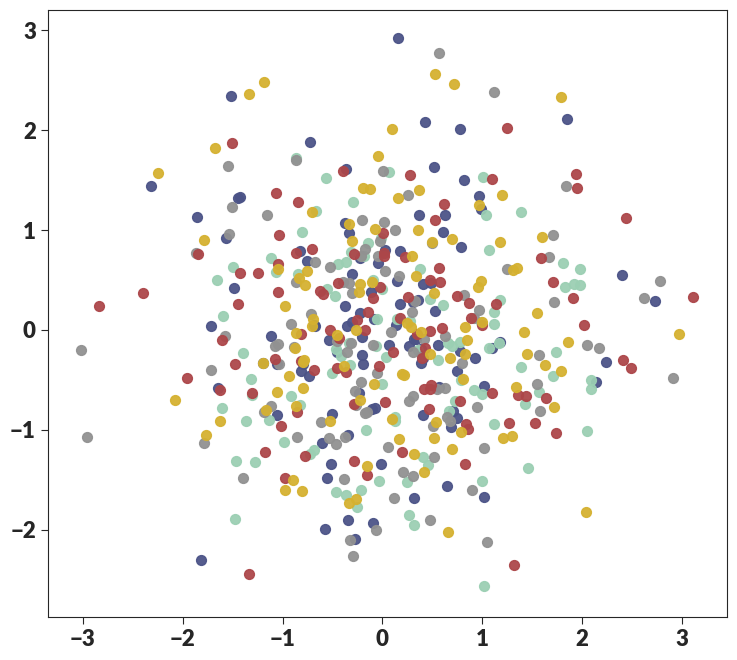

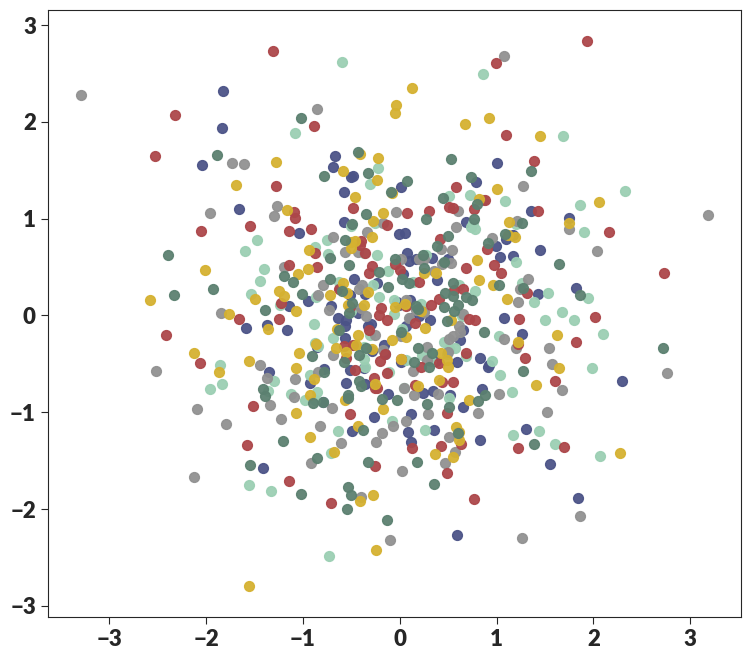

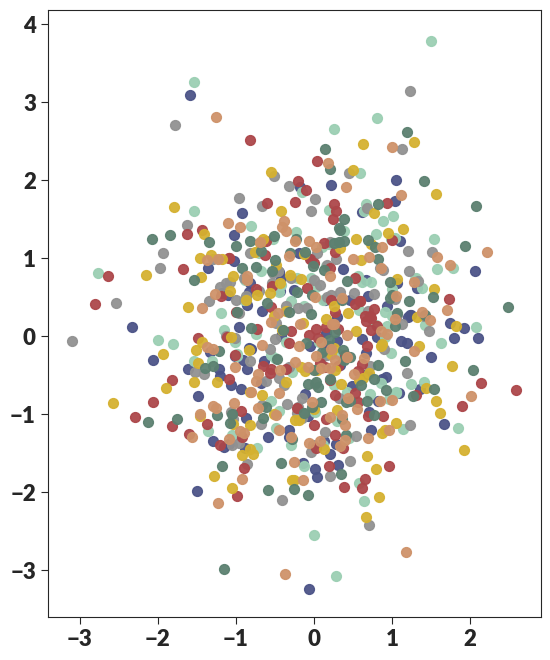

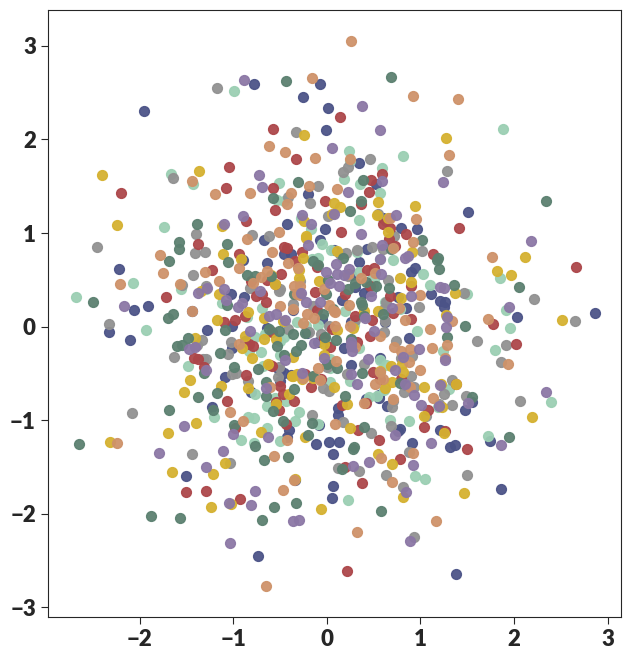

In [455]:
for i in range(len(new_cycle)):
    fig, ax = bpl.subplots()
    for c in range(i+1):
        xs = np.random.normal(0, 1, 100)
        ys = np.random.normal(0, 1, 100)
        
        ax.scatter(xs, ys, c=new_cycle[c], s=50, label=new_cycle[c])
        ax.equal_scale()